## Imports

In [2]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [3]:
import gc
import numpy as np
import pandas as pd
import lightgbm as lgbm
import category_encoders as ce
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(2024)

#DATA_DIR = '/kaggle/input/optiver-realized-volatility-prediction'

In [4]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/RBS DL 2025/PRO/data'

Mounted at /content/drive


## Read data

In [5]:
# df_book_train_raw = pd.read_parquet(f'{DATA_DIR}/book_train.parquet')
# df_book_test_raw = pd.read_parquet(f'{DATA_DIR}/book_test.parquet')

# df_trade_train_raw = pd.read_parquet(f'{DATA_DIR}/trade_train.parquet')
# df_trade_test_raw = pd.read_parquet(f'{DATA_DIR}/trade_test.parquet')

df_train_raw = pd.read_csv(f'{DATA_DIR}/train.csv')
df_test_raw = pd.read_csv(f'{DATA_DIR}/test.csv')

In [6]:
# display(df_book_train_raw.head(5))
# display(df_trade_train_raw.head(5))

## Pre-processing functions

In [7]:
def calc_log_ret(prices):
    x = np.log(prices)
    return np.diff(x, prepend=[x[0]])

### Book data

In [8]:
def book_preprocess(file_path):

    df = pd.read_parquet(file_path)

    df['wap1'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])
    df['log_ret1'] = df.groupby('time_id')['wap1'].transform(lambda x: calc_log_ret(x.to_numpy())) # Each time_id is a window having several time stamps

    df['wap2'] = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])
    df['log_ret2'] = df.groupby('time_id')['wap2'].transform(lambda x: calc_log_ret(x.to_numpy())) # Each time_id is a window having several time stamps

    df['wap_balance'] = df['wap1'] - df['wap2']

    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']

    df['total_volume'] = df['ask_size1'] + df['ask_size2'] + df['bid_size1'] + df['bid_size2']
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    create_feature_dict = {
        'log_ret1': ['std'],
        'log_ret2': ['std'],
        'wap_balance': ['mean', 'std'],
        'price_spread': ['mean', 'std'],
        'bid_spread': ['mean', 'std'],
        'ask_spread': ['mean', 'std'],
        'volume_imbalance': ['mean', 'std'],
        'total_volume': ['mean', 'std'],
        'wap1': ['mean', 'std'],
        'wap2': ['mean', 'std']
    }

    df_feature = pd.DataFrame(
        df.groupby(['time_id']).agg(create_feature_dict)
    ).reset_index()
    df_feature.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature.columns]

    last_seconds = [300, 120]
    for second in last_seconds:
        df_feature_sec = pd.DataFrame(
            df[df['seconds_in_bucket'] >= 600 - second]
        ).groupby(['time_id']).agg(create_feature_dict).reset_index()
        df_feature_sec.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix(f'_{second}')

        df_feature = pd.merge(
            df_feature, df_feature_sec,
            how='left', left_on='time_id',right_on=f'time_id_{second}'
        )
        df_feature.drop([f'time_id_{second}'], axis=1, inplace=True)

    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = str(stock_id) + '-' + df_feature['time_id'].astype(str)
    df_feature.drop(['time_id'], axis=1, inplace=True)

    return df_feature

In [9]:
book_preprocess(f'{DATA_DIR}/book_train.parquet/stock_id=0').head(5)

,log_ret1_std,log_ret2_std,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,bid_spread_mean,bid_spread_std,ask_spread_mean,ask_spread_std,...,ask_spread_std_120,volume_imbalance_mean_120,volume_imbalance_std_120,total_volume_mean_120,total_volume_std_120,wap1_mean_120,wap1_std_120,wap2_mean_120,wap2_std_120,row_id
0,0.000259,0.000403,0.000065,0.000484,0.000852,0.000211,0.000176,0.000162,-0.000151,0.000126,...,0.000130,147.654545,72.189365,243.727273,100.391909,1.003425,0.000550,1.003332,0.000613,0-5
1,0.000085,0.000175,0.000033,0.000261,0.000394,0.000157,0.000142,0.000148,-0.000135,0.000065,...,0.000059,101.847826,93.155060,414.152174,169.493883,1.000549,0.000241,1.000441,0.000286,0-11
2,0.000173,0.000351,-0.000138,0.000389,0.000725,0.000164,0.000197,0.000170,-0.000198,0.000171,...,0.000127,167.892857,115.704393,452.250000,109.446630,0.997963,0.000402,0.998135,0.000564,0-16
3,0.000235,0.000333,0.000199,0.000409,0.000860,0.000280,0.000190,0.000199,-0.000108,0.000091,...,0.000013,178.153846,107.321826,530.307692,171.968691,0.998078,0.000511,0.998278,0.000579,0-31
4,0.000143,0.000246,-0.000008,0.000317,0.000397,0.000130,0.000191,0.000083,-0.000109,0.000076,...,0.000070,120.333333,101.074517,370.333333,131.539601,0.999464,0.000259,0.999723,0.000203,0-62


### Trade data

In [10]:
def trade_preprocess(file_path):
    df = pd.read_parquet(file_path)
    df['log_ret'] = df.groupby('time_id')['price'].transform(lambda x: calc_log_ret(x.to_numpy())) # Each time_id is a window having several time stamps

    aggregate_dictionary = {
        'log_ret': ['std'],
        'size': ['sum', 'mean', 'std'],
        'order_count': ['sum', 'mean', 'std'],
    }
    df_feature = df.groupby('time_id').agg(aggregate_dictionary).reset_index()
    df_feature.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature.columns]

    last_seconds = [300, 120]
    for second in last_seconds:
        df_feature_sec = pd.DataFrame(
            df[df['seconds_in_bucket'] >= 600 - second]
        ).groupby(['time_id']).agg(aggregate_dictionary).reset_index()
        df_feature_sec.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix(f'_{second}')

        df_feature = pd.merge(
            df_feature, df_feature_sec,
            how='left', left_on='time_id',right_on=f'time_id_{second}'
        )
        df_feature.drop([f'time_id_{second}'], axis=1, inplace=True)

    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = str(stock_id) + '-' + df_feature['time_id'].astype(str)
    df_feature.drop(['time_id'], axis=1, inplace=True)

    return df_feature

In [11]:
trade_preprocess(f'{DATA_DIR}/trade_train.parquet/stock_id=0').head(5)

,log_ret_std,size_sum,size_mean,size_std,order_count_sum,order_count_mean,order_count_std,log_ret_std_300,size_sum_300,size_mean_300,...,order_count_mean_300,order_count_std_300,log_ret_std_120,size_sum_120,size_mean_120,size_std_120,order_count_sum_120,order_count_mean_120,order_count_std_120,row_id
0,0.000319,3179,79.475000,118.375107,110,2.750000,2.467741,0.000290,1587.0,75.571429,...,2.571429,2.292846,0.000314,739.0,67.181818,149.948537,27.0,2.454545,1.752920,0-5
1,0.000165,1289,42.966667,77.815203,57,1.900000,1.446756,0.000151,900.0,56.250000,...,2.250000,1.807392,0.000181,826.0,103.250000,111.347269,20.0,2.500000,2.267787,0-11
2,0.000387,2161,86.440000,113.587000,68,2.720000,2.300725,0.000275,1189.0,99.083333,...,3.166667,2.691175,0.000305,681.0,97.285714,112.658354,17.0,2.428571,1.812654,0-16
3,0.000387,1962,130.800000,144.828569,59,3.933333,4.043808,0.000381,1556.0,172.888889,...,5.111111,4.702245,0.000202,509.0,254.500000,276.478751,10.0,5.000000,4.242641,0-31
4,0.000190,1791,81.409091,117.914682,89,4.045455,4.099678,0.000143,1219.0,110.818182,...,4.909091,4.887833,0.000206,43.0,10.750000,15.585784,14.0,3.500000,4.358899,0-62


In [12]:
def preprocessor(stock_id_list, train_mode = True):

    from joblib import Parallel, delayed # parallel computing to save time

    df = pd.DataFrame()

    def for_joblib(stock_id):
        if train_mode:
            file_path_book = f'{DATA_DIR}/book_train.parquet/stock_id={stock_id}'
            file_path_trade = f'{DATA_DIR}/trade_train.parquet/stock_id={stock_id}'
        else:
            file_path_book = f'{DATA_DIR}/book_test.parquet/stock_id={stock_id}'
            file_path_trade = f'{DATA_DIR}/trade_test.parquet/stock_id={stock_id}'

        df_tmp = pd.merge(
            book_preprocess(file_path_book),
            trade_preprocess(file_path_trade),
            on='row_id', how='left'
        )
        return pd.concat([df,df_tmp])

    df = Parallel(n_jobs=-1, verbose=1)(
            delayed(for_joblib)(stock_id) for stock_id in stock_id_list
        )

    df =  pd.concat(df, ignore_index = True)
    return df

- Make train dataset

In [13]:
train_stock_id_list = df_train_raw['stock_id'].unique()
df_train = preprocessor(train_stock_id_list, train_mode = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  5.0min finished


In [14]:
df_train_tmp = df_train_raw.copy()
df_train_tmp['row_id'] = df_train_raw['stock_id'].astype(str) + '-' + df_train_raw['time_id'].astype(str)
df_train_tmp = df_train_tmp[['row_id', 'target']]
df_train = pd.merge(
    df_train, df_train_tmp,
    on = ['row_id'], how = 'right'
)
df_train['stock_id'] = df_train['row_id'].apply(lambda x: int(x.split('-')[0])).astype('category')
del(df_train_tmp)

- Make test dataset

In [15]:
test_stock_id_list = df_test_raw['stock_id'].unique()
df_test = preprocessor(test_stock_id_list, train_mode = False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [16]:
df_test_tmp = df_test_raw.copy()
df_test_tmp['row_id'] = df_test_raw['stock_id'].astype(str) + '-' + df_test_raw['time_id'].astype(str)
df_test_tmp = df_test_tmp[['row_id']]
df_test = pd.merge(
    df_test, df_test_tmp,
    on = ['row_id'], how = 'right'
)
df_test['stock_id'] = df_test['row_id'].apply(lambda x: int(x.split('-')[0])).astype('category')
del(df_test_tmp)

- Make datasets to pass into model

In [17]:
X_train = df_train.drop(['target', 'row_id'], axis=1).copy()
Y_train = df_train['target'].copy()

X_test = df_test.drop(['row_id'], axis=1).copy()

- Do target encoding

In [18]:
t_encoder = ce.TargetEncoder()
t_encoder.fit(df_train['stock_id'], df_train['target'])

X_train['stock_id'] = t_encoder.transform(X_train['stock_id'])
X_test['stock_id'] = t_encoder.transform(X_test['stock_id'])

In [19]:
gc.collect()

26

## Train

In [20]:
def rmspe(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(
            np.square(((y_true - y_pred) / y_true))
        ))

In [21]:
model = lgbm.LGBMRegressor(
                objective = 'regression',
                verbosity = -1,
                n_jobs = -1
            )
cv_search_space = {
    'n_estimators': np.arange(20, 2000, 40),
    'max_depth': np.arange(2, 20, 1),
    'num_leaves': np.arange(20, 100, 20),
    'min_child_samples': np.arange(10, 1000, 50),
    'max_bin': np.arange(10, 200, 5),
    'reg_alpha': np.linspace(0.01, 5.0, 5),
    'reg_lambda': np.linspace(0.01, 5.0, 5),
    'colsample_bytree': np.linspace(0.1, 0.5, 5),
    'min_child_weight': np.linspace(0.01, 10, 2),
    'subsample': np.linspace(0.01, 1, 2),
}
rand_cv = RandomizedSearchCV(
    estimator = model,
    param_distributions = cv_search_space,
    scoring = make_scorer(rmspe, greater_is_better=False),
    n_iter = 1,
    verbose = 3,
    cv = 3,
    n_jobs = 1
)
rand_cv.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.2, max_bin=80, max_depth=11, min_child_samples=10, min_child_weight=10.0, n_estimators=1900, num_leaves=40, reg_alpha=1.2575, reg_lambda=2.505, subsample=0.01;, score=-0.364 total time=  30.1s
[CV 2/3] END colsample_bytree=0.2, max_bin=80, max_depth=11, min_child_samples=10, min_child_weight=10.0, n_estimators=1900, num_leaves=40, reg_alpha=1.2575, reg_lambda=2.505, subsample=0.01;, score=-0.321 total time=  30.6s
[CV 3/3] END colsample_bytree=0.2, max_bin=80, max_depth=11, min_child_samples=10, min_child_weight=10.0, n_estimators=1900, num_leaves=40, reg_alpha=1.2575, reg_lambda=2.505, subsample=0.01;, score=-0.277 total time=  30.9s


RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(n_jobs=-1, objective='regression',
                                           verbosity=-1),
                   n_iter=1, n_jobs=1,
                   param_distributions={'colsample_bytree': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'max_bin': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
       140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195]),
                                        'max_depth': arr...
        900,  940,  980, 1020, 1060, 1100, 1140, 1180, 1220, 1260, 1300,
       1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620, 1660, 1700, 1740,
       1780, 1820, 1860, 1900, 1940, 1980]),
                                        'num_leaves': array([20, 40, 60, 80]),
                                        'reg_alpha': array([0.01  , 1.2575, 2.505 , 3.7525, 5.    ]),
                                        'reg_lambda': array([0.01  , 1.2575, 2.505 , 3.7525, 5.    ]),
                                        'subsample': array([0.01, 1.  ])},
                   scoring=make_scorer(rmspe, greater_is_better=False, response_method='predict'),
                   verbose=3)

In [22]:
gc.collect()

30

## Model analysis

In [23]:
best_model = rand_cv.best_estimator_

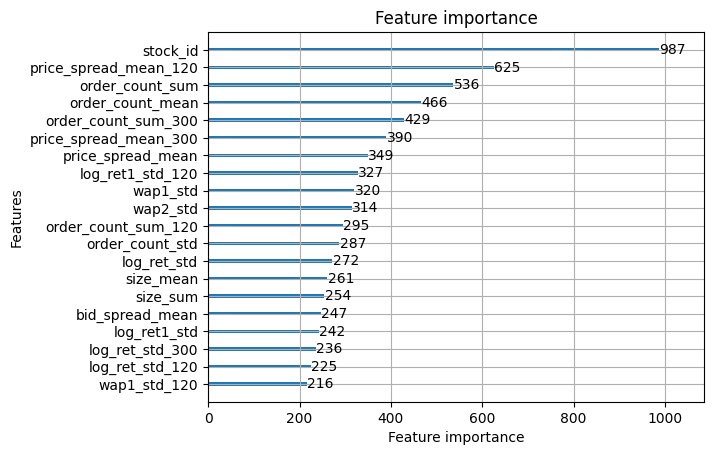

In [24]:
lgbm.plot_importance(best_model, max_num_features=20)
plt.show()

## Predict

In [25]:
Y_train_pred = best_model.predict(X_train)
rmspe(Y_train.values, Y_train_pred)

np.float64(0.3004458226131493)

In [26]:
Y_test_pred = best_model.predict(X_test)
Y_test_pred

array([0.00238902, 0.00224391, 0.00224391])

In [27]:
df_submission = df_test_raw.copy()[['row_id']]
df_submission['target'] = Y_test_pred
df_submission.to_csv('submission.csv', index=False)